```` 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/
https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
 ````

In [2]:
# get data
import pandas as pd
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()


,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [29]:
# prepare data
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# get dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [30]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
1,0.003283,0.002811,0.002673,0.003249,0.003761,0.152627,0.001608,0.0,0.017991,0.499282,...,0.454397,0.001930,0.0,0.005898,0.418290,0.047789,0.001376,0.743184,0.15182,0.058838
2,0.003587,0.003283,0.003083,0.003756,0.011551,0.454397,0.001930,0.0,0.005898,0.418290,...,0.483667,0.002252,0.0,0.006118,0.419270,0.063409,0.001679,0.760774,0.15182,0.083439
3,0.003862,0.003587,0.003144,0.004055,0.015802,0.483667,0.002252,0.0,0.006118,0.419270,...,0.557376,0.001448,0.0,0.004710,0.411143,0.085457,0.001884,0.732300,0.15182,0.071119
4,0.005367,0.003862,0.004754,0.004387,0.022128,0.557376,0.001448,0.0,0.004710,0.411143,...,0.447703,0.000322,0.0,0.004414,0.411241,0.106870,0.004816,0.682717,0.15182,0.080230
5,0.003355,0.005367,0.005031,0.002056,0.031220,0.447703,0.000322,0.0,0.004414,0.411241,...,0.605909,0.002011,0.0,0.000530,0.412416,0.111119,0.007271,0.716469,0.15182,0.067833


In [34]:
# split data
values = reframed.values
n_train_days = 365 * 4
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
train_X, train_y = train[:, :1], train[:, 1]
test_X, test_y = test[:, :1], test[:, 1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, 14))
test_X = test_X.reshape((test_X.shape[0], 1, 14))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


ValueError: cannot reshape array of size 1460 into shape (1460,1,14)

Epoch 1/10
21/21 - 1s - loss: 0.0712 - val_loss: 0.0316
Epoch 2/10
21/21 - 0s - loss: 0.0457 - val_loss: 0.0766
Epoch 3/10
21/21 - 0s - loss: 0.0372 - val_loss: 0.0901
Epoch 4/10
21/21 - 0s - loss: 0.0348 - val_loss: 0.0741
Epoch 5/10
21/21 - 0s - loss: 0.0334 - val_loss: 0.0539
Epoch 6/10
21/21 - 0s - loss: 0.0330 - val_loss: 0.0430
Epoch 7/10
21/21 - 0s - loss: 0.0298 - val_loss: 0.0433
Epoch 8/10
21/21 - 0s - loss: 0.0286 - val_loss: 0.0416
Epoch 9/10
21/21 - 0s - loss: 0.0279 - val_loss: 0.0290
Epoch 10/10
21/21 - 0s - loss: 0.0277 - val_loss: 0.0211


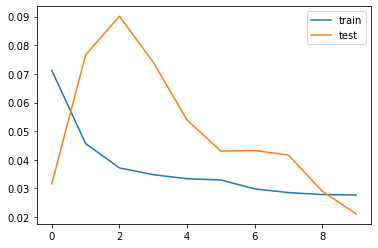

In [6]:
# create model
# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

try:
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=72,
                        validation_data=(test_X, test_y), verbose=2, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
except Exception as e:
    print("Error: ", e)

In [7]:
try:
    yhat = model.predict(test_X)
    print(yhat)
except Exception as e:
    print("Error: ")
    print(e)

[[0.04290769]
 [0.03547386]
 [0.0706437 ]
 [0.08363149]
 [0.07180008]
 [0.06866653]
 [0.06886155]
 [0.0807102 ]
 [0.06870137]
 [0.06830999]
 [0.07556157]
 [0.08263546]
 [0.06665047]
 [0.0641987 ]
 [0.06428431]
 [0.03794074]
 [0.04787261]
 [0.05867606]
 [0.0507577 ]
 [0.04821431]
 [0.05212659]
 [0.06170459]
 [0.03500137]
 [0.02070243]
 [0.04245714]
 [0.04403954]
 [0.04350322]
 [0.05470092]
 [0.06015826]
 [0.05080983]
 [0.0383274 ]
 [0.04639217]
 [0.05739788]
 [0.0493312 ]
 [0.05266562]
 [0.04795906]
 [0.02496203]
 [0.03904217]
 [0.0605232 ]
 [0.0736244 ]
 [0.08205202]
 [0.06865062]
 [0.07010753]
 [0.04150724]
 [0.05368439]
 [0.06333574]
 [0.0551082 ]
 [0.06841332]
 [0.06764205]
 [0.06371186]
 [0.04767413]
 [0.06187408]
 [0.08027225]
 [0.083542  ]
 [0.08487294]
 [0.06148337]
 [0.05454344]
 [0.03986877]
 [0.0329898 ]
 [0.05964863]
 [0.06031999]
 [0.05237814]
 [0.04935825]
 [0.05820078]
 [0.02942944]
 [0.03100743]
 [0.05219365]
 [0.05029681]
 [0.05847362]
 [0.05703803]
 [0.06153264]
 [0.03

In [25]:
import numpy as np
def inverse_transform(X, scaler):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), 15))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:, :]

inverse_transform(yhat, scaler)

array([[3.64400546e+03, 3.64404392e+03, 3.74779329e+03, ...,
        6.30802898e+00, 8.11913800e+00, 7.09999490e+03],
       [3.14761077e+03, 3.14764257e+03, 3.24104381e+03, ...,
        6.30126717e+00, 7.40549054e+00, 6.13637009e+03],
       [5.49608072e+03, 5.49614404e+03, 5.63850285e+03, ...,
        6.33325765e+00, 1.07817951e+01, 1.06953309e+04],
       ...,
       [3.79226120e+03, 3.79230165e+03, 3.89914165e+03, ...,
        6.31004849e+00, 8.33227955e+00, 7.38779594e+03],
       [3.32616135e+03, 3.32619554e+03, 3.42331895e+03, ...,
        6.30369935e+00, 7.66218580e+00, 6.48298089e+03],
       [4.00283099e+03, 4.00287426e+03, 4.11410392e+03, ...,
        6.31291684e+00, 8.63500760e+00, 7.79656396e+03]])

In [28]:
z = np.concatenate((yhat, test_X.reshape((test_X.shape[0], test_X.shape[2]))[:, 1:]), axis=1)
scaler.inverse_transform(z)

ValueError: operands could not be broadcast together with shapes (365,29) (15,) (365,29) 

In [ ]:
try:
    # invert scaling for forecast
    # test_X_ = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

except Exception as e:
    print("Error: ", e)
    pass


In [ ]:
# model summary
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import concatenate

try:
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
except Exception as e:
    print("Error: ", e)